# Quantum. Lab 6. Phase estimation (using IQFT)

Author:
- ***Nikita Makarevich (Student ID: 153989)***

In [38]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
import qiskit.visualization as qvis
from qiskit_aer import Aer
import matplotlib.pyplot as plt
import pandas as pd
from typing import Any
from qiskit.circuit.library import QFTGate

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# selection of quantum simulator (or processor)
# backend = Aer.get_backend("qasm_simulator")
backend = Aer.get_backend("aer_simulator")

In [39]:
def plot_results(
    counts: list[dict], *, axs: tuple[plt.Axes, plt.Axes] | None = None
) -> tuple[plt.Axes, plt.Axes]:
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    qvis.plot_histogram(
        counts,
        ax=axs[0],
    )
    qvis.plot_distribution(
        counts,
        legend=[f"Execution {i + 1}" for i in range(len(counts))],
        ax=axs[1],
    )

    for ax in (axs[0], axs[1]):
        old_texts = ax.texts[:]  # copy list of text objects
        for t in old_texts:
            t.remove()

    for ax in (axs[0], axs[1]):
        for p in ax.patches:  # each bar
            height = p.get_height()
            x = p.get_x() + p.get_width() / 2
            ax.annotate(
                f"{height}" if float(height).is_integer() else f"{height:.2f}",
                (x, height),
                ha="center",
                va="bottom",
                rotation=45,
                fontsize=9,
            )

    axs[0].set_title("Distribution [counts]")
    axs[1].set_title("Probabilities")

    return (axs[0], axs[1])

## Defining Phase Estimation Circuit Functions

In [40]:
def create_phase_estimation_circuit(m: int = 10, theta: float = 0.7) -> QuantumCircuit:
    control_register = QuantumRegister(m, name="Control")
    target_register = QuantumRegister(1, name="|ψ>")
    output_register = ClassicalRegister(m, name="Result")
    qc = QuantumCircuit(control_register, target_register, output_register)

    # Prepare the eigenvector |ψ>
    qc.x(target_register)
    qc.barrier()

    # Perform phase estimation
    for index, qubit in enumerate(control_register):
        qc.h(qubit)
        for _ in range(2**index):
            qc.cp(2 * np.pi * theta, qubit, target_register)
    qc.barrier()

    # Do inverse quantum Fourier transform
    qc.compose(
        QFTGate(m).inverse(),
        inplace=True
    )

    qc.measure(range(m), range(m))

    return qc


def run_phase_estimation_circuit(qc: QuantumCircuit) -> dict:
    backend = AerSimulator()

    qc_transpiled = transpile(qc, backend)
    sampler = Sampler(mode=backend)
    job = sampler.run([qc_transpiled])

    result = job.result()

    counts = result[0].data.Result.get_counts()

    return counts

(<Axes: title={'center': 'Distribution [counts]'}, ylabel='Count'>,
 <Axes: title={'center': 'Probabilities'}, ylabel='Quasi-probability'>)

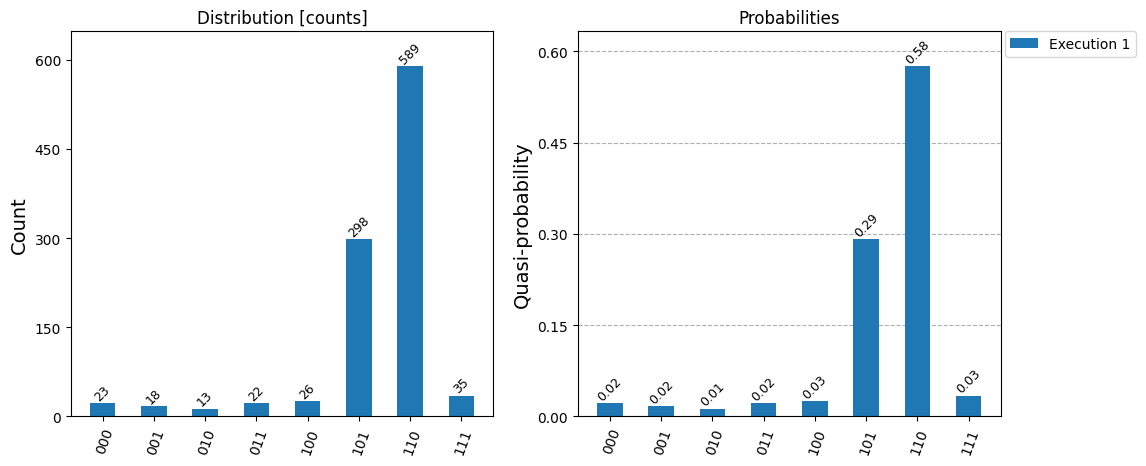

In [41]:
qc = create_phase_estimation_circuit(theta=0.7, m=3)
counts = run_phase_estimation_circuit(qc)
plot_results([counts])

## Running the actual experiment

In [42]:
def show_phase_estimation_experiment(ns: list[int], theta: float):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    records: list[dict[str, Any]] = []
    for n in ns:
        qc = create_phase_estimation_circuit(m=n, theta=theta)
        counts = run_phase_estimation_circuit(qc)

        max_key = max(counts, key=counts.get)
        highlighted_state = int(max_key, 2)
        estimated_phase = highlighted_state / (2**n)
        uncertainty = ((estimated_phase - theta) / theta) * 100
        records.append({
            "n": n,
            "highlighted_state": highlighted_state,
            "estimated_phase": estimated_phase,
            "uncertainty": uncertainty,
        })

    results_df = pd.DataFrame.from_records(records)
    print(results_df.to_string())

    max_n = max(ns)

    axs[0].set_title(f"Phase estimation $\\theta_e$ (where $\\theta={theta}$)")
    axs[0].set_xlabel(r" Number of qubits ")
    axs[0].set_ylabel(r"$\theta_e$")
    axs[0].set_xlim([0, max_n + 0.2])
    axs[0].plot(results_df["n"], results_df["estimated_phase"], "g^")
    axs[0].hlines(y=theta, xmin=0.0, xmax=max_n + 0.2, colors="k", linestyles="dashed")

    axs[1].set_title(
        r"Phase estimation uncertainty $\frac{\theta_e - \theta}{\theta} \cdot 100\%$"
    )
    axs[1].set_xlabel(r" Number of qubits ")
    axs[1].set_ylabel(r"$\frac{\theta_e - \theta}{\theta} \cdot 100\%$")
    axs[1].set_xlim([0, max_n + 0.2])
    axs[1].plot(results_df["n"], results_df["uncertainty"], "g^")
    axs[1].hlines(y=0.0, xmin=0.0, xmax=max_n + 0.2, colors="k", linestyles="dashed")

    n  highlighted_state  estimated_phase  uncertainty
0   1                  1         0.500000    51.515152
1   2                  1         0.250000   -24.242424
2   3                  3         0.375000    13.636364
3   4                  5         0.312500    -5.303030
4   5                 11         0.343750     4.166667
5   6                 21         0.328125    -0.568182
6   7                 42         0.328125    -0.568182
7   8                 84         0.328125    -0.568182
8   9                169         0.330078     0.023674
9  10                338         0.330078     0.023674


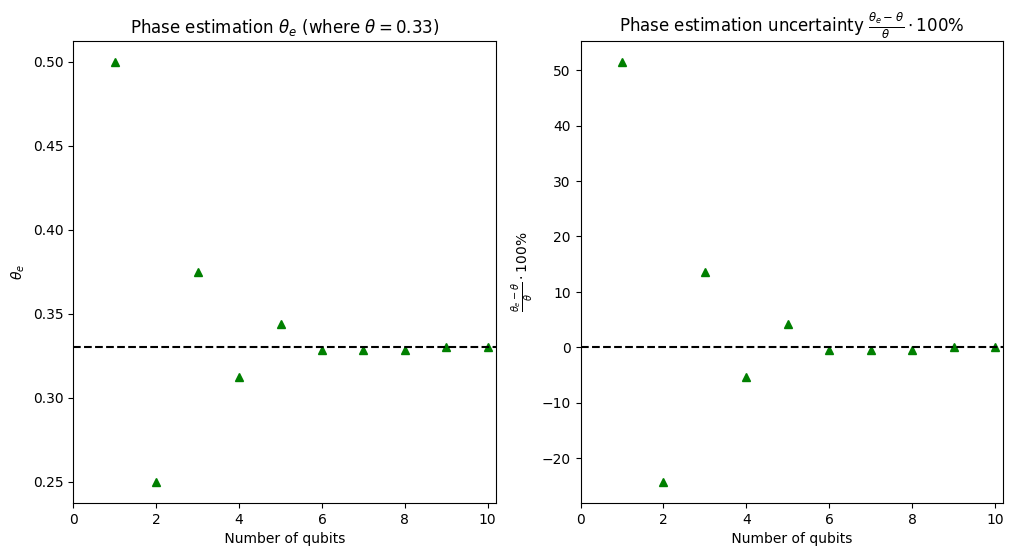

In [43]:
THETA: float = 0.33
show_phase_estimation_experiment(ns=list(range(1, 11)), theta=THETA)